## Imports 

In [27]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read The Data
We will load the formatted data from the previous notebook

In [37]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


In [38]:
train_features.head(10)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

Here's the distribution of the Energy Star Score

Text(0.5,1,'Energy Star Score Distribution')

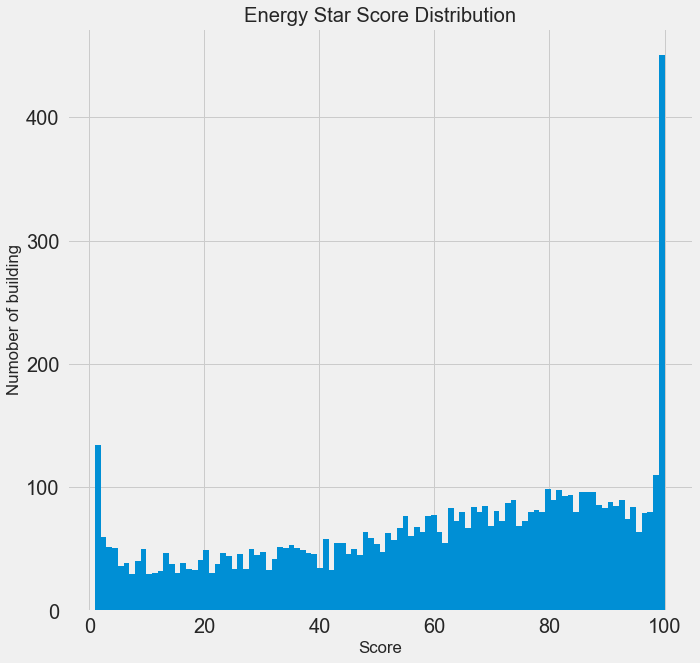

In [39]:
figsize(10,10)
# histo plot for scort
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins =100)
plt.xlabel('Score')
plt.ylabel('Numober of building')
plt.title('Energy Star Score Distribution')

## Evaluating and Comparing ML models:
The objective is to determine which model holds the most prominant for future development( such as hyperparameter tuning)

We are comparing using the <b>mean absolute error </b>. A baseline model that guessed the median value of the score was off by an average of <b> 25 points </b>.

## Imputing Missing Values

Standard ML models cannot deal with missing values, which means that we need to find out a way to fill these or discard any features with missing values. Since we already discarded the features with more than 50% missing values, here we will be imputing the missing values. 

Various methods of data imputation can be found here: http://www.stat.columbia.edu/~gelman/arm/missing.pdf

In the code below we are creating a <a href='http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html'> Sklean.preprocessing </a> Imputer object to fill the missing values with the median of the coulmn. We train the imputer using `Imputer.fit` method on on the training data but not the testing data. We then transform (using `Imputer.transform`) both the training data and testing data. This means that the missing values in the testing set are filled in with the median value of the corresponding columns in the training set. We have to do it this way rather than because at deployment time, we will have to impute the missing values in new observations based on the previous training data. This is one way to avoid the problem known as data leakage where information from the testing set "leaks" into the training process.


In [40]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [41]:
# checking if there are still any missing values
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))   

Missing values in training features:  0
Missing values in testing features:   0


In [42]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [46]:
X.shape

(6622, 64)

After imputation, all the features are real-valued. 
More sophisticated methods on imputation can be found <a href = 'https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146'> here</a>

## Feature Scaling

The final step to take before we can build our models is to <a href = 'https://en.wikipedia.org/wiki/Feature_scaling'>scale the features </a>. This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm. Linear Regression and Random Forest <a href = 'https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data'>do not require feature scaling</a>, but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms.
There are two ways to <a href='http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html'>scale features</a>:
For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.
For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization

Here is a good article about normalization and standardization:
https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/

As with imputation, when we train the scaling object, we want to use only the training set. When we transform features, we will transform both the training set and the testing set.

In [48]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [49]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Model Evaluation

We will compare five different machine learning models using the great Scikit-Learn library:
- 1.Linear Regression
- 2.Support Vector Machine Regression
- 3.Random Forest Regression
- 4.Gradient Boosting Regression
- 5.K-Nearest Neighbors Regression

To compare the models, we are going to be mostly using the Scikit-Learn defaults for the model hyperparameters. Generally these will perform decently, but should be optimized before actually using a model. At first, we just want to determine the baseline performance of each model, and then we can select the best performing model for further optimization using hyperparameter tuning. Remember that the default hyperparameters will get a model up and running, but nearly always should be adjusted using some sort of search to find the best settings for your problem!

Here is what the Scikit-learn documentation says about the defaults:

__Sensible defaults__: `Whenever an operation requires a user-defined parameter,
an appropriate default value is defined by the library. The default value
should cause the operation to be performed in a sensible way (giving a baseline
solution for the task at hand.)`

One of the best parts about scikit-learn is that all models are implemented in an identical manner: once you know how to build one, you can implement an extremely diverse array of models. Here we will implement the entire training and testing procedures for a number of models in just a few lines of code.

In [50]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [51]:
# linear regression model
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [52]:
# SVM
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [55]:
# Random Forest
rf = RandomForestRegressor(random_state=60)
rf_mae = fit_and_evaluate(rf)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % rf_mae)

Random Forest Regression Performance on the test set: MAE = 10.0147


In [56]:
# Gradient Boost
gradient_boost = GradientBoostingRegressor(random_state=60)
gb_mae = fit_and_evaluate(gradient_boost)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gb_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0132


In [57]:
# KNN
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


Text(0.5,1,'Model Comparison on Test MAE')

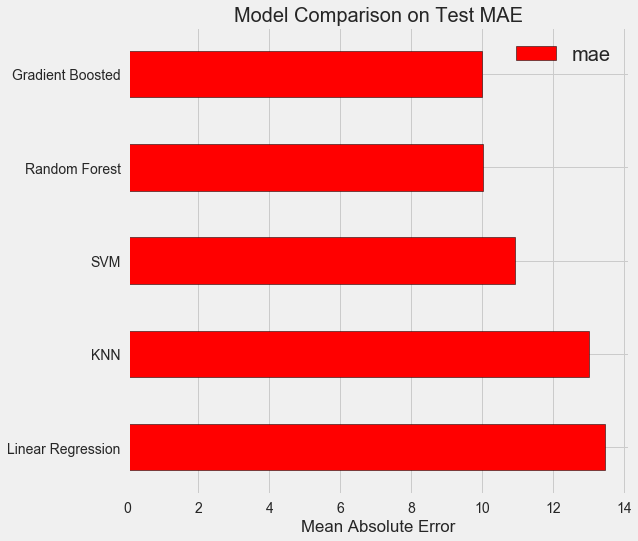

In [59]:
# Graphically compare different models

plt.style.use('fivethirtyeight')

figsize(8,8)

# Dataframe to hold the results
model_comparison = pd.DataFrame(
{
    'model':['Linear Regression', 'SVM', 'Random Forest','Gradient Boosted','KNN'],
    'mae':[lr_mae,svm_mae, rf_mae, gb_mae, knn_mae]
})

# Horizontal bar charts of test mae
model_comparison.sort_values(by = 'mae', ascending = False).plot(
x = 'model', y = 'mae', kind = 'barh',
color = 'red', edgecolor = 'black')

# plot formatting
plt.ylabel('')
plt.yticks(size = 14)
plt.xlabel('Mean Absolute Error')
plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20)


Depending on the run (the exact results change slighty each time), the gradient boosting regressor performs the best followed by the random forest. I have to admit that this is not the most fair comparison because we are using mostly the default hyperparameters. Especially with the Support Vector Regressor, the hyperparameters have a significant influence on performance. (the random forest and gradient boosting methods are great for starting out because the performance is less dependent on the model settings). Nonetheless, from these results, we can conclude that machine learning is applicable because all the models significantly outperform the baseline!

## Model Optimization
In machine learning, optimizing the model means finding the best set of hyperparameters for a particular problem.

### Hyperparameters

There is a contrast between model hyperparameters and model parameters:
link :https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/
- Model hyperparameters are best thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or the number of neighbors used in K Nearest Neighbors Regression.
- Model parameters are what the model learns during training, such as the weights in the linear regression.

We as data scientists control a model by choosing the hyperparameters, and these choices can have a significant effect on the final performance of the model (although usually not as great of an effect as getting more data or engineering features).
<a href ='http://scikit-learn.org/stable/modules/grid_search.html'>Tuning the model hyperparameters</a> controls the balance of under vs over fitting in a model. We can try to correct for under-fitting by making a more complex model, such as using more trees in a random forest or more layers in a deep neural network. A model that underfits has high bias, and occurs when our model does not have enough capacity (degrees of freedom) to learn the relationship between the features and the target. We can try to correct for overfitting by limiting the complexity of the model and applying regularization. This might mean decreasing the degree of a polynomial regression, or adding dropout layers to a deep neural network. A model that overfits has high variance and in effect has memorized the training set. Both underfitting and overfitting lead to poor generalization performance on the test set.
The problem with choosing the hyperparameters is that no set will work best across all problems. Therefore, for every new dataset, we have to find the best settings. This can be a time-consuming process, but luckily there are several options for performing this procedure in Scikit-Learn. Even better, new libraries, such as TPOT by epistasis labs, is aiming to do this process automatically for you! For now, we will stick to doing this manually (sort of) in Scikit-Learn, but stay tuned for an article on automatic model selection!



### Hyperparameter Tuning with Random Search and Cross Validation
We can choose the best hyperparameters for a model through random search and cross validation.
- Random search refers to the method in which we choose hyperparameters to evaluate:
we define a range of options, and then randomly select combinations to try. This is in contrast to grid search which evaluates every single combination we specify. Generally, random search is better when we have limited knowledge of the best model hyperparameters and we can use random search to narrow down the options and then use grid search with a more limited range of options.
- Cross validation is the method used to assess the performance of the hyperparameters: 
Rather than splitting the training set up into separate training and validation sets which reduces the amount of training data we can use, we use K-Fold Cross Validation. This means dividing the training data into K folds, and then going through an iterative process where we first train on K-1 of the folds and then evaluate performance on the kth fold. We repeat this process K times so eventually we will have tested on every example in the training data with the key that each iteration we are testing on data that we did not train on. At the end of K-fold cross validation, we take the average error on each of the K iterations as the final performance measure and then train the model on all the training data at once. The performance we record is then used to compare different combinations of hyperparameters.

A picture of k-fold cross validation using k = 5 is shown below:
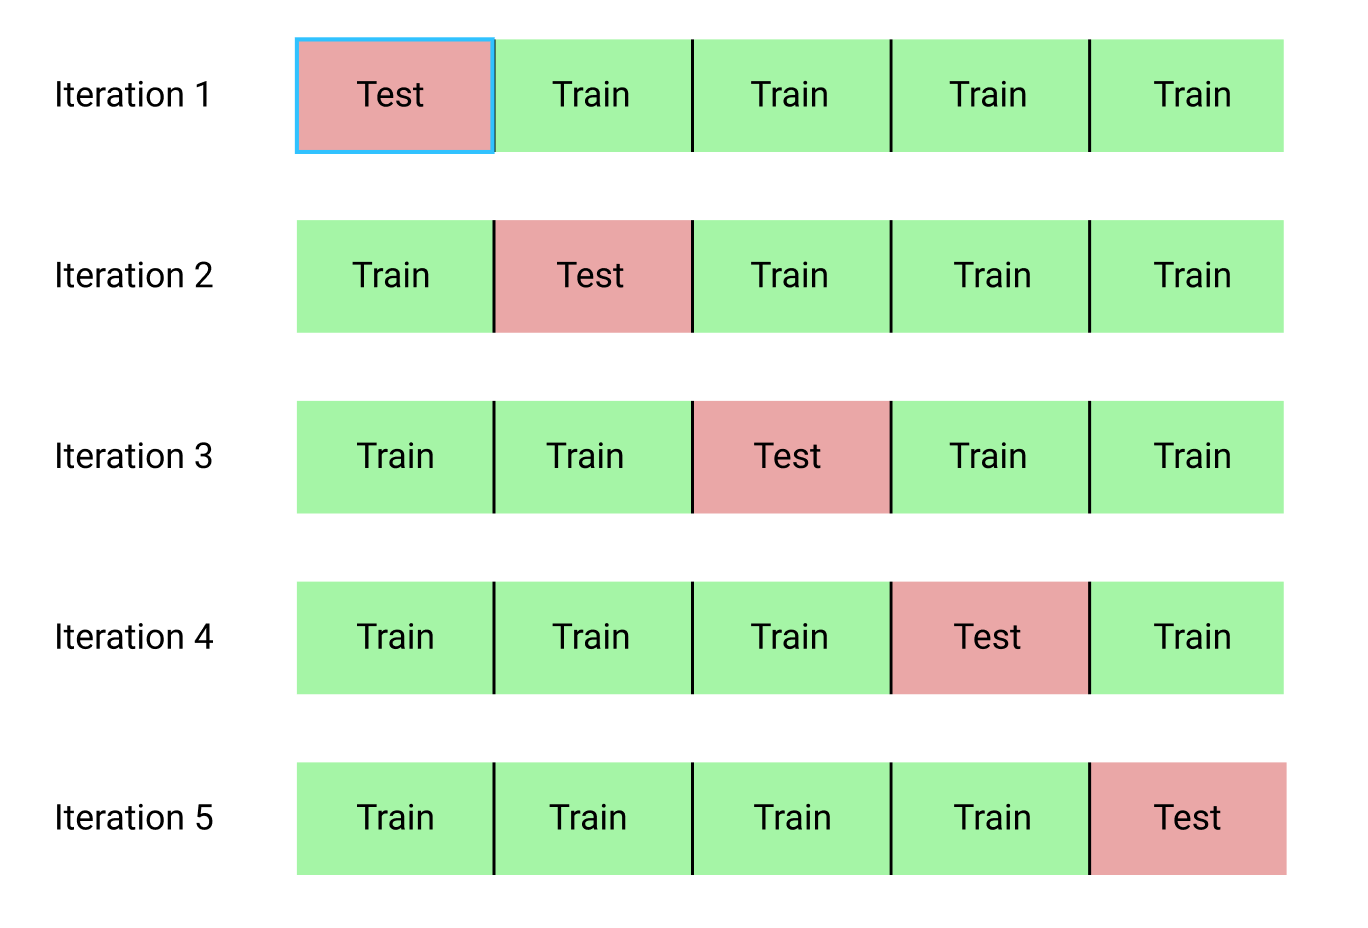

Here we will implement random search with cross validation to select the optimal hyperparameters for the gradient boosting regressor. We first define a grid then peform an iterative process of: randomly sample a set of hyperparameters from the grid, evaluate the hyperparameters using 4-fold cross-validation, and then select the hyperparameters with the best performance.


In [61]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

Reading link for sklearn's hyperparameter: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

In the code below, we will create the Randomized Search Object passing in the following parameters:
- estimator: the model 
- param_distributions: the distribution of parameters we defined
- cv the number of folds to use for k-fold cross validation
- n_iter: the number of different combinations to try
- scoring: which metric to use when evaluating candidates
- n_jobs: number of cores to run in parallel (-1 will use all available)
- verbose: how much information to display (1 displays a limited amount)
- return_train_score: return the training score for each cross-validation fold
- random_state: fixes the random number generator used so we get the same results every run

The Randomized Search Object is trained the same way as any other scikit-learn model. After training, we can compare all the different hyperparameter combinations and find the best performing one.

In [63]:
# Create  the model to use for hyperparameter tuning

model = GradientBoostingRegressor(random_state=42)

# set up the random search with 4-fold cross validations
random_cv = RandomizedSearchCV(estimator=model,
                              param_distributions=hyperparameter_grid,
                              cv =4, n_iter = 25,
                              scoring = 'neg_mean_absolute_error',
                              n_jobs = -1, verbose = 1,
                              return_train_score = True,
                              random_state=42)

In [64]:
# fit on the training data
random_cv.fit(X,y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

In [66]:
# Get all of the CV results and sort them by the test performance

random_results = pd.DataFrame(random_cv.cv_results_).sort_values(
by = 'mean_test_score', ascending = False)

random_results.head(15)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
12,12.377399,0.023588,-8.998761,-6.893790,lad,5,None,6,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",1,-8.859381,-7.027368,-8.773966,-6.837958,-9.325139,-6.869084,-9.036779,-6.840749,0.181853,0.001384,0.210901,0.078077
3,12.702505,0.023098,-9.041004,-4.465253,huber,5,None,8,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",2,-8.868788,-4.482073,-8.904791,-4.326121,-9.315304,-4.823009,-9.075321,-4.229809,0.299935,0.001549,0.176509,0.225313
9,7.842378,0.016010,-9.192518,-6.987506,huber,3,auto,2,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",3,-9.134318,-7.007604,-9.042461,-7.088986,-9.441179,-6.913108,-9.152240,-6.940327,0.063545,0.000364,0.149456,0.067939
0,2.294376,0.006518,-9.196413,-7.293554,ls,5,auto,6,2,100,"{'n_estimators': 100, 'min_samples_split': 2, ...",4,-9.101610,-7.302003,-9.026912,-7.312645,-9.456259,-7.173397,-9.201033,-7.386171,0.019256,0.000359,0.162211,0.076569
7,6.309208,0.017677,-9.350555,-7.073741,ls,3,auto,6,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",5,-9.146159,-7.089709,-9.199358,-7.103749,-9.699696,-7.021418,-9.357220,-7.080088,0.024578,0.001067,0.215966,0.031358
10,71.205176,0.094994,-9.376652,-0.400401,huber,10,None,6,10,1100,"{'n_estimators': 1100, 'min_samples_split': 10...",6,-9.261256,-0.378166,-9.243867,-0.459465,-9.528538,-0.393491,-9.473096,-0.370483,2.635474,0.004406,0.125816,0.035092
19,14.774682,0.030881,-9.381693,-8.202307,lad,3,auto,2,6,1100,"{'n_estimators': 1100, 'min_samples_split': 6,...",7,-9.379335,-8.311796,-9.382576,-8.658903,-9.473980,-7.820534,-9.290880,-8.017995,0.433864,0.001305,0.064740,0.316303
2,47.096731,0.051992,-9.419115,-0.165987,huber,10,auto,2,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",8,-9.385744,-0.164859,-9.288317,-0.193613,-9.572674,-0.164415,-9.429825,-0.141062,1.501688,0.000632,0.102366,0.018629
16,19.851638,0.051910,-9.446787,-4.801009,ls,3,None,6,4,1500,"{'n_estimators': 1500, 'min_samples_split': 4,...",9,-9.246573,-4.821677,-9.317156,-4.876202,-9.798950,-4.776650,-9.424668,-4.729506,0.071304,0.003659,0.212942,0.054284
21,5.302673,0.025610,-9.460295,-5.666205,huber,5,log2,4,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",10,-9.393840,-5.684121,-9.289175,-5.742441,-9.750806,-5.571781,-9.407503,-5.666476,0.030316,0.001434,0.173829,0.061337


In [ ]:
random_cv.best_estimator_

The best gradient boosted model has the following hyperparameters:
- loss = lad
- n_estimators = 500
- max_depth = 5
- min_samples_leaf = 6
- min_samples_split = 6
- max_features = None (This means that max_features = n_features according to the docs)

Using random search is a good method to narrow down the possible hyperparameters to try. Initially, we had no idea which combination would work the best, but this at least narrows down the range of options.

We could use the random search results to inform a grid search by creating a grid with hyperparameters close to those that worked best during the randomized search. However, rather than evaluating all of these settings again, I will focus on a single one, the number of trees in the forest (n_estimators). By varying only one hyperparameter, we can directly observe how it affects performance. In the case of the number of trees, we would expect to see a significant affect on the amount of under vs overfitting.

Here we will use grid search with a grid that only has the n_estimators hyperparameter. We will evaluate a range of trees then plot the training and testing performance to get an idea of what increasing the number of trees does for our model. We will fix the other hyperparameters at the best values returned from random search to isolate the number of trees effect.

In [69]:
# Create a range of trees to evaluate
trees_grid = {
    'n_estimators':[100,150,200,250,300,400,450,500,550,600,650,700,750,800]
}

model = GradientBoostingRegressor(loss= 'lad', max_depth= 5,
                                 min_samples_leaf = 6,
                                 min_samples_split = 6,
                                 max_features= None,
                                random_state = 42
                                 )

# Grid Search object using the tree range and the randomforest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [70]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 14 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  1.4min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

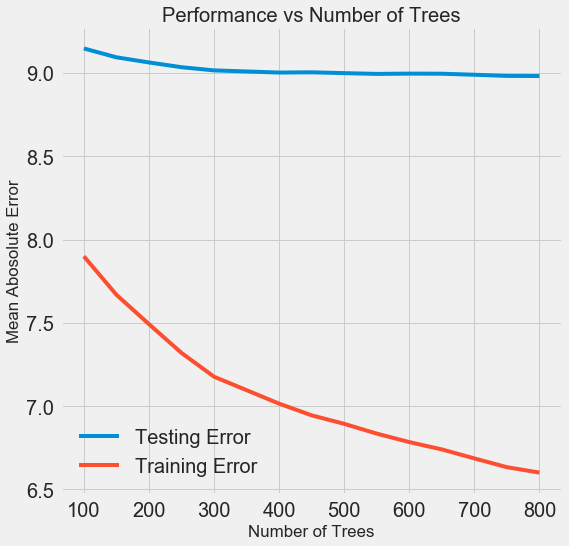

In [71]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [72]:
results.sort_values('mean_test_score', ascending = False).head(5)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
13,16.206921,0.023676,-8.981504,-6.601028,800,{'n_estimators': 800},1,-8.825018,-6.739448,-8.757257,-6.648109,-9.297520,-6.486269,-9.046451,-6.530287,0.426361,0.000708,0.211453,0.099437
12,19.882399,0.032674,-8.982193,-6.633542,750,{'n_estimators': 750},2,-8.830294,-6.772908,-8.750657,-6.660453,-9.299357,-6.520818,-9.048696,-6.579989,0.400806,0.003136,0.213125,0.094501
11,19.069496,0.033077,-8.989100,-6.686214,700,{'n_estimators': 700},3,-8.835777,-6.812928,-8.754819,-6.695770,-9.313318,-6.611240,-9.052721,-6.624919,0.546203,0.000514,0.216536,0.079884
8,13.729723,0.026863,-8.994138,-6.835031,550,{'n_estimators': 550},4,-8.853451,-7.003413,-8.755897,-6.781878,-9.325442,-6.809121,-9.041991,-6.745712,0.228871,0.001615,0.217136,0.099783
10,17.854466,0.030261,-8.995319,-6.740194,650,{'n_estimators': 650},5,-8.850857,-6.864375,-8.754361,-6.721452,-9.325111,-6.708191,-9.051181,-6.666758,0.404891,0.000621,0.218405,0.074480


From this plot, it's pretty clear that our model is overfitting! The training error is significantly lower than the testing error, which shows that the model is learning the training data very well but then is not able to generalize to the test data as well. Moveover, as the number of trees increases, the amount of overfitting increases. Both the test and training error decrease as the number of trees increase but the training error decreases more rapidly.

There will always be a difference between the training error and testing error (the training error is always lower) but if there is a significant difference, we want to try and reduce overfitting, either by getting more training data or reducing the complexity of the model through hyperparameter tuning or regularization. For the gradient boosting regressor, some options include reducing the number of trees, reducing the max depth of each tree, and increasing the minimum number of samples in a leaf node. For anyone who wants to go further into the gradient boosting regressor, here is a great article. For now, we will use the model with the best performance and accept that it may be overfitting to the training set.

Based on the cross validation results, the best model using 800 trees and achieves a cross validation error under 9. This indicates that the average cross-validation estimate of the Energy Star Score is within 9 points of the true answer!


## Evaluate Final Model on the Test Set

We will use the best model from hyperparameter tuning to make predictions on the testing set. Remember, our model has never seen the test set before, so this performance should be a good indicator of how the model would perform if deployed in the real world.

For comparison, we can also look at the performance of the default model. The code below creates the final model, trains it (with timing), and evaluates on the test set.

In [73]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [74]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

796 ms ± 21.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [75]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

12.2 s ± 117 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [76]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 10.0118.
Final model performance on the test set:   MAE = 9.0446.


The final model does out-perform the baseline model by about 10%, but at the cost of significantly increased running time (it's about 12 times slower on my machine). Machine learning is often a field of tradeoffs: bias vs variance, acccuracy vs interpretability, accuracy vs running time, and the final decision of which model to use depends on the situation. Here, the increase in run time is not an impediment, because while the relative difference is large, the absolute magnitude of the training time is not significant. In a different situation, the balance might not be the same so we would need to consider what we are optimizing for and the limitations we have to work with.

To get a sense of the predictions, we can plot the distribution of true values on the test set and the predicted values on the test set.

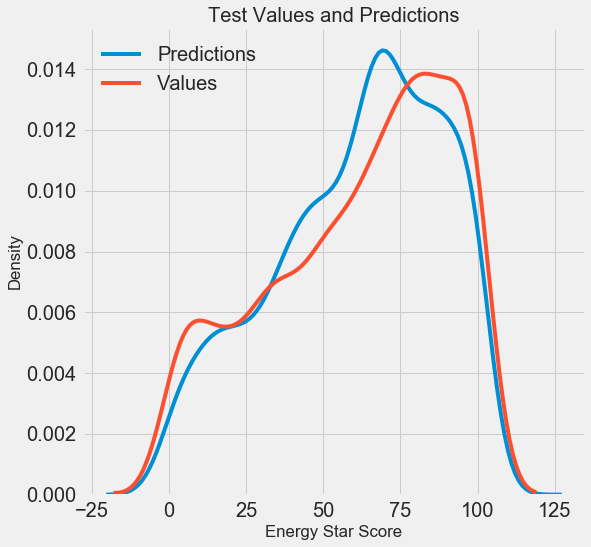

In [77]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values rather than to the actual peak at 100. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median.

Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low).

Text(0.5,1,'Distribution of Residuals')

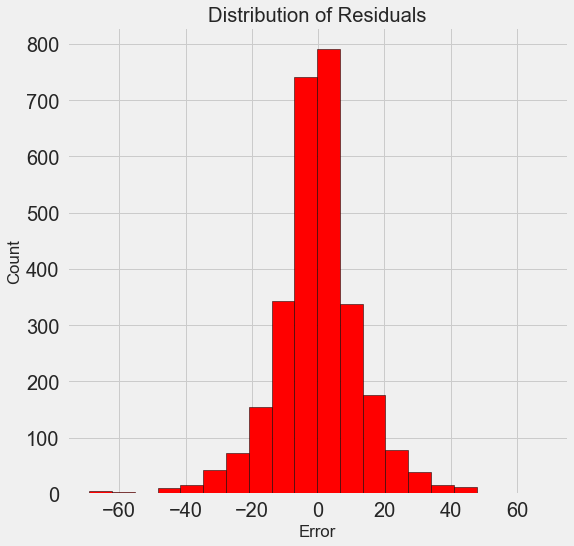

In [78]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals')

The residuals are close to normally disributed, with a few noticeable outliers on the low end. These indicate errors where the model estimate was far below that of the true value.

## Conclusions

In this notebook, we covered crucial concepts in the machine learning pipeline:

- Imputing missing values
- Evaluating and comparing several machine learning methods
- Hyperparameter tuning a machine learning model using random search and cross validation
- Evaluating the best model on the testing set

The results showed us that machine learning is applicable to our problem, with the final model able to the predict the Energy Star Score of a building to within 9.1 points. We also saw that hyperparamter tuning was able to improve the performance of the model although at a considerable cost in terms of time invested. This is a good reminder that proper feature engineering and gathering more data (if possible!) has a much larger pay-off than fine-tuning the model. We also observed the trade-off in run-time versus accuracy, which is one of many considerations we have to take into account when designing machine learning models.

